In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os
import cv2
import matplotlib.pyplot as plt
import argparse
import time
from tqdm.auto import tqdm
import keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, random_split
from pytorch_model_summary import summary
from efficientnet_pytorch import EfficientNet
import warnings
warnings.filterwarnings('ignore')

from Constants import *
from dataset import *
from model import *


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [3]:
gpu = torch.cuda.is_available()
gpu

False

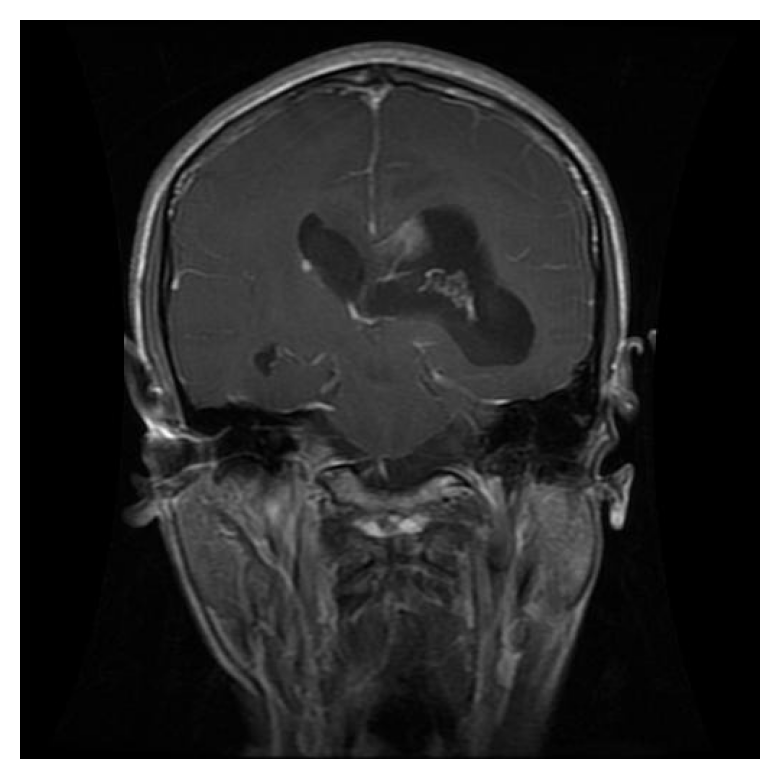

In [4]:
image = plt.imread("../data/Training/glioma/Tr-glTr_0004.jpg")
plt.axis("off")
plt.imshow(image)

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                           shuffle = True,
                                                           image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                           batch_size = BATCH_SIZE)

Found 5712 files belonging to 4 classes.


In [6]:
image_count = len(dataset)
image_count

357

In [7]:
class_names = dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


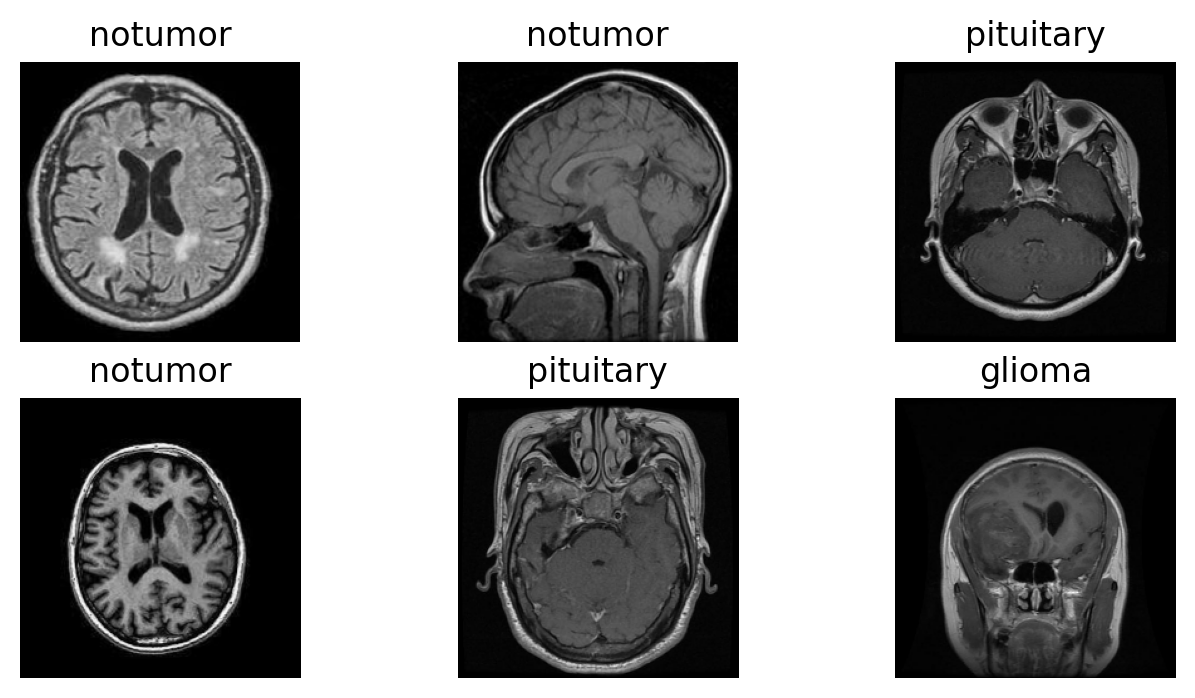

In [8]:
plt.figure(figsize = (8, 4))
for image_batch, label_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def train_preprocessing(IMAGE_SIZE):
    train_augmenting = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomVerticalFlip(p = 0.5),
        transforms.GaussianBlur(kernel_size = (5, 9),sigma = (0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    
    return train_augmenting

In [10]:
dataset = datasets.ImageFolder(TRAIN_PATH,
                               transform = (train_preprocessing(IMAGE_SIZE)))
dataset_size = [int(len(dataset) * 0.75), len(dataset) - int(len(dataset) * 0.75)]
train_set, validation_set = random_split(dataset, dataset_size)

def file_loader(train_set, validation_set):
    train_loader = DataLoader(
        train_set,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers = NUM_WORKERS
    )
    validation_loader = DataLoader(
        validation_set,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = NUM_WORKERS
    )
    
    return train_loader, validation_loader

In [11]:
dataset.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [12]:
plt.style.use('ggplot')

def save_model(epochs, model, optimizer, criterion):
    torch.save({
        'epoch' : epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : criterion,
    }, f"../outputs2/model.pth")
    
    
def save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss):
    # Accuracy plot
    plt.figure(figsize = (12, 10))
    plt.plot(train_accuracy, color = 'black', label = 'training accuracy')
    plt.plot(validation_accuracy, color = 'blue', label = 'validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"../outputs2/accuracy.png")
    
    # Loss plot
    plt.figure(figsize = (12, 10))
    plt.plot(train_loss, color = 'black', label = 'training loss')
    plt.plot(validation_loss, color = 'blue', label = 'validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"../outputs2/loss.png")

In [13]:
# Using efficientnet
    
    
def build_model(pretrained = True, fine_tune = True, num_classes = 10):

    # Load the pre-trained ResNet model
    model = EfficientNet.from_pretrained('efficientnet-b0')

    # Freeze all layers if fine-tuning is not enabled
    return model


In [14]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print("Training...")
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    for i, data in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        # Forward prop
        outputs = model(image)
        
        # Calculating loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        
        # Calculating accuracy
        _, prediction = torch.max(outputs.data, 1)
        train_running_correct += (prediction == labels).sum().item()
        
        # Backward prop
        loss.backward()

        # Update weights
        optimizer.step()
        
    epoch_loss = train_running_loss / counter
    epoch_accuracy = 100 * (train_running_correct / len(trainloader.dataset))
    
    return epoch_loss, epoch_accuracy

In [15]:
def validate(model, testloader, criterion):
    model.eval()
    print('validation...')
    validation_running_loss = 0.0
    validation_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # Forward prop
            outputs = model(image)
            
            # Calculating loss
            loss = criterion(outputs, labels)
            validation_running_loss += loss.item()
            
            # Calculating accuracy
            _, prediction = torch.max(outputs.data, 1)
            validation_running_correct += (prediction == labels).sum().item()
            
    epoch_loss = validation_running_loss / counter
    epoch_accuracy = 100 * (validation_running_correct / len(testloader.dataset))
    
    return epoch_loss, epoch_accuracy


In [16]:
args = {'learning_rate' : 0.0001, 'epochs' : 15}
dataset_classes = dataset.class_to_idx

In [17]:
# Load training and validation data loaders
train_loader, validation_loader = file_loader(train_set, validation_set)

In [18]:
%%time

# Learning parameters
learning_rate = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}\n")


# Make custom model and call here
    
model = build_model(
        pretrained = True,
        fine_tune = True,
        num_classes = len(dataset_classes)
    ).to(device)
    
 
# Total parameters and trainable parameters
total_parameters = sum(p.numel() for p in model.parameters())
print(f"{total_parameters:,} parameters.")
trainable_parameters = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{trainable_parameters:,} training parameters.")
    
    # Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    # Loss
criterion = nn.CrossEntropyLoss()
    
    # Tracking loss and accuracy
train_loss, validation_loss = [], []
train_accuracy, validation_accuracy = [], []
    
    # Train
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_loss_per_epoch, train_accuracy_per_epoch = train(model,
                                                               train_loader,
                                                               optimizer,
                                                               criterion)
    val_loss_per_epoch, val_accuracy_per_epoch = validate(model,
                                                              validation_loader,
                                                              criterion)
    train_loss.append(train_loss_per_epoch)
    validation_loss.append(val_loss_per_epoch)
    train_accuracy.append(train_accuracy_per_epoch)
    validation_accuracy.append(val_accuracy_per_epoch)
    print(f"Training loss: {train_loss_per_epoch:.3f}, Training accuracy: {train_accuracy_per_epoch:.3f}")
    print(f"Validation loss: {val_loss_per_epoch:.3f}, Validation accuracy: {val_accuracy_per_epoch:.3f}")
    print("~ " * 100)
    time.sleep(3)
        
        
    # Save model
save_model(epochs, model, optimizer, criterion)        
print("Done")

Running on: cpu
Learning rate: 0.0001
Epochs: 15



Loaded pretrained weights for efficientnet-b0
5,288,548 parameters.
5,288,548 training parameters.
Epoch 1 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 1.356, Training accuracy: 74.813
Validation loss: 0.292, Validation accuracy: 91.457
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 2 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.248, Training accuracy: 91.153
Validation loss: 0.198, Validation accuracy: 93.557
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 3 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.179, Training accuracy: 93.721
Validation loss: 0.138, Validation accuracy: 95.518
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 4 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.136, Training accuracy: 94.981
Validation loss: 0.118, Validation accuracy: 96.709
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 5 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.116, Training accuracy: 95.495
Validation loss: 0.094, Validation accuracy: 97.339
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 6 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.090, Training accuracy: 96.919
Validation loss: 0.090, Validation accuracy: 97.479
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 7 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.070, Training accuracy: 97.806
Validation loss: 0.063, Validation accuracy: 98.109
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 8 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.061, Training accuracy: 97.899
Validation loss: 0.083, Validation accuracy: 97.759
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 9 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.049, Training accuracy: 98.319
Validation loss: 0.067, Validation accuracy: 98.249
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 10 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.051, Training accuracy: 98.459
Validation loss: 0.057, Validation accuracy: 98.249
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 11 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.036, Training accuracy: 98.856
Validation loss: 0.061, Validation accuracy: 98.319
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 12 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.034, Training accuracy: 98.739
Validation loss: 0.064, Validation accuracy: 98.739
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 13 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.034, Training accuracy: 98.739
Validation loss: 0.059, Validation accuracy: 98.319
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 14 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.033, Training accuracy: 98.973
Validation loss: 0.071, Validation accuracy: 98.319
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Epoch 15 of 15
Training...


  0%|          | 0/268 [00:00<?, ?it/s]

validation...


  0%|          | 0/90 [00:00<?, ?it/s]

Training loss: 0.031, Training accuracy: 98.950
Validation loss: 0.083, Validation accuracy: 98.179
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
Done
CPU times: total: 13h 4min 9s
Wall time: 7h 20min 28s


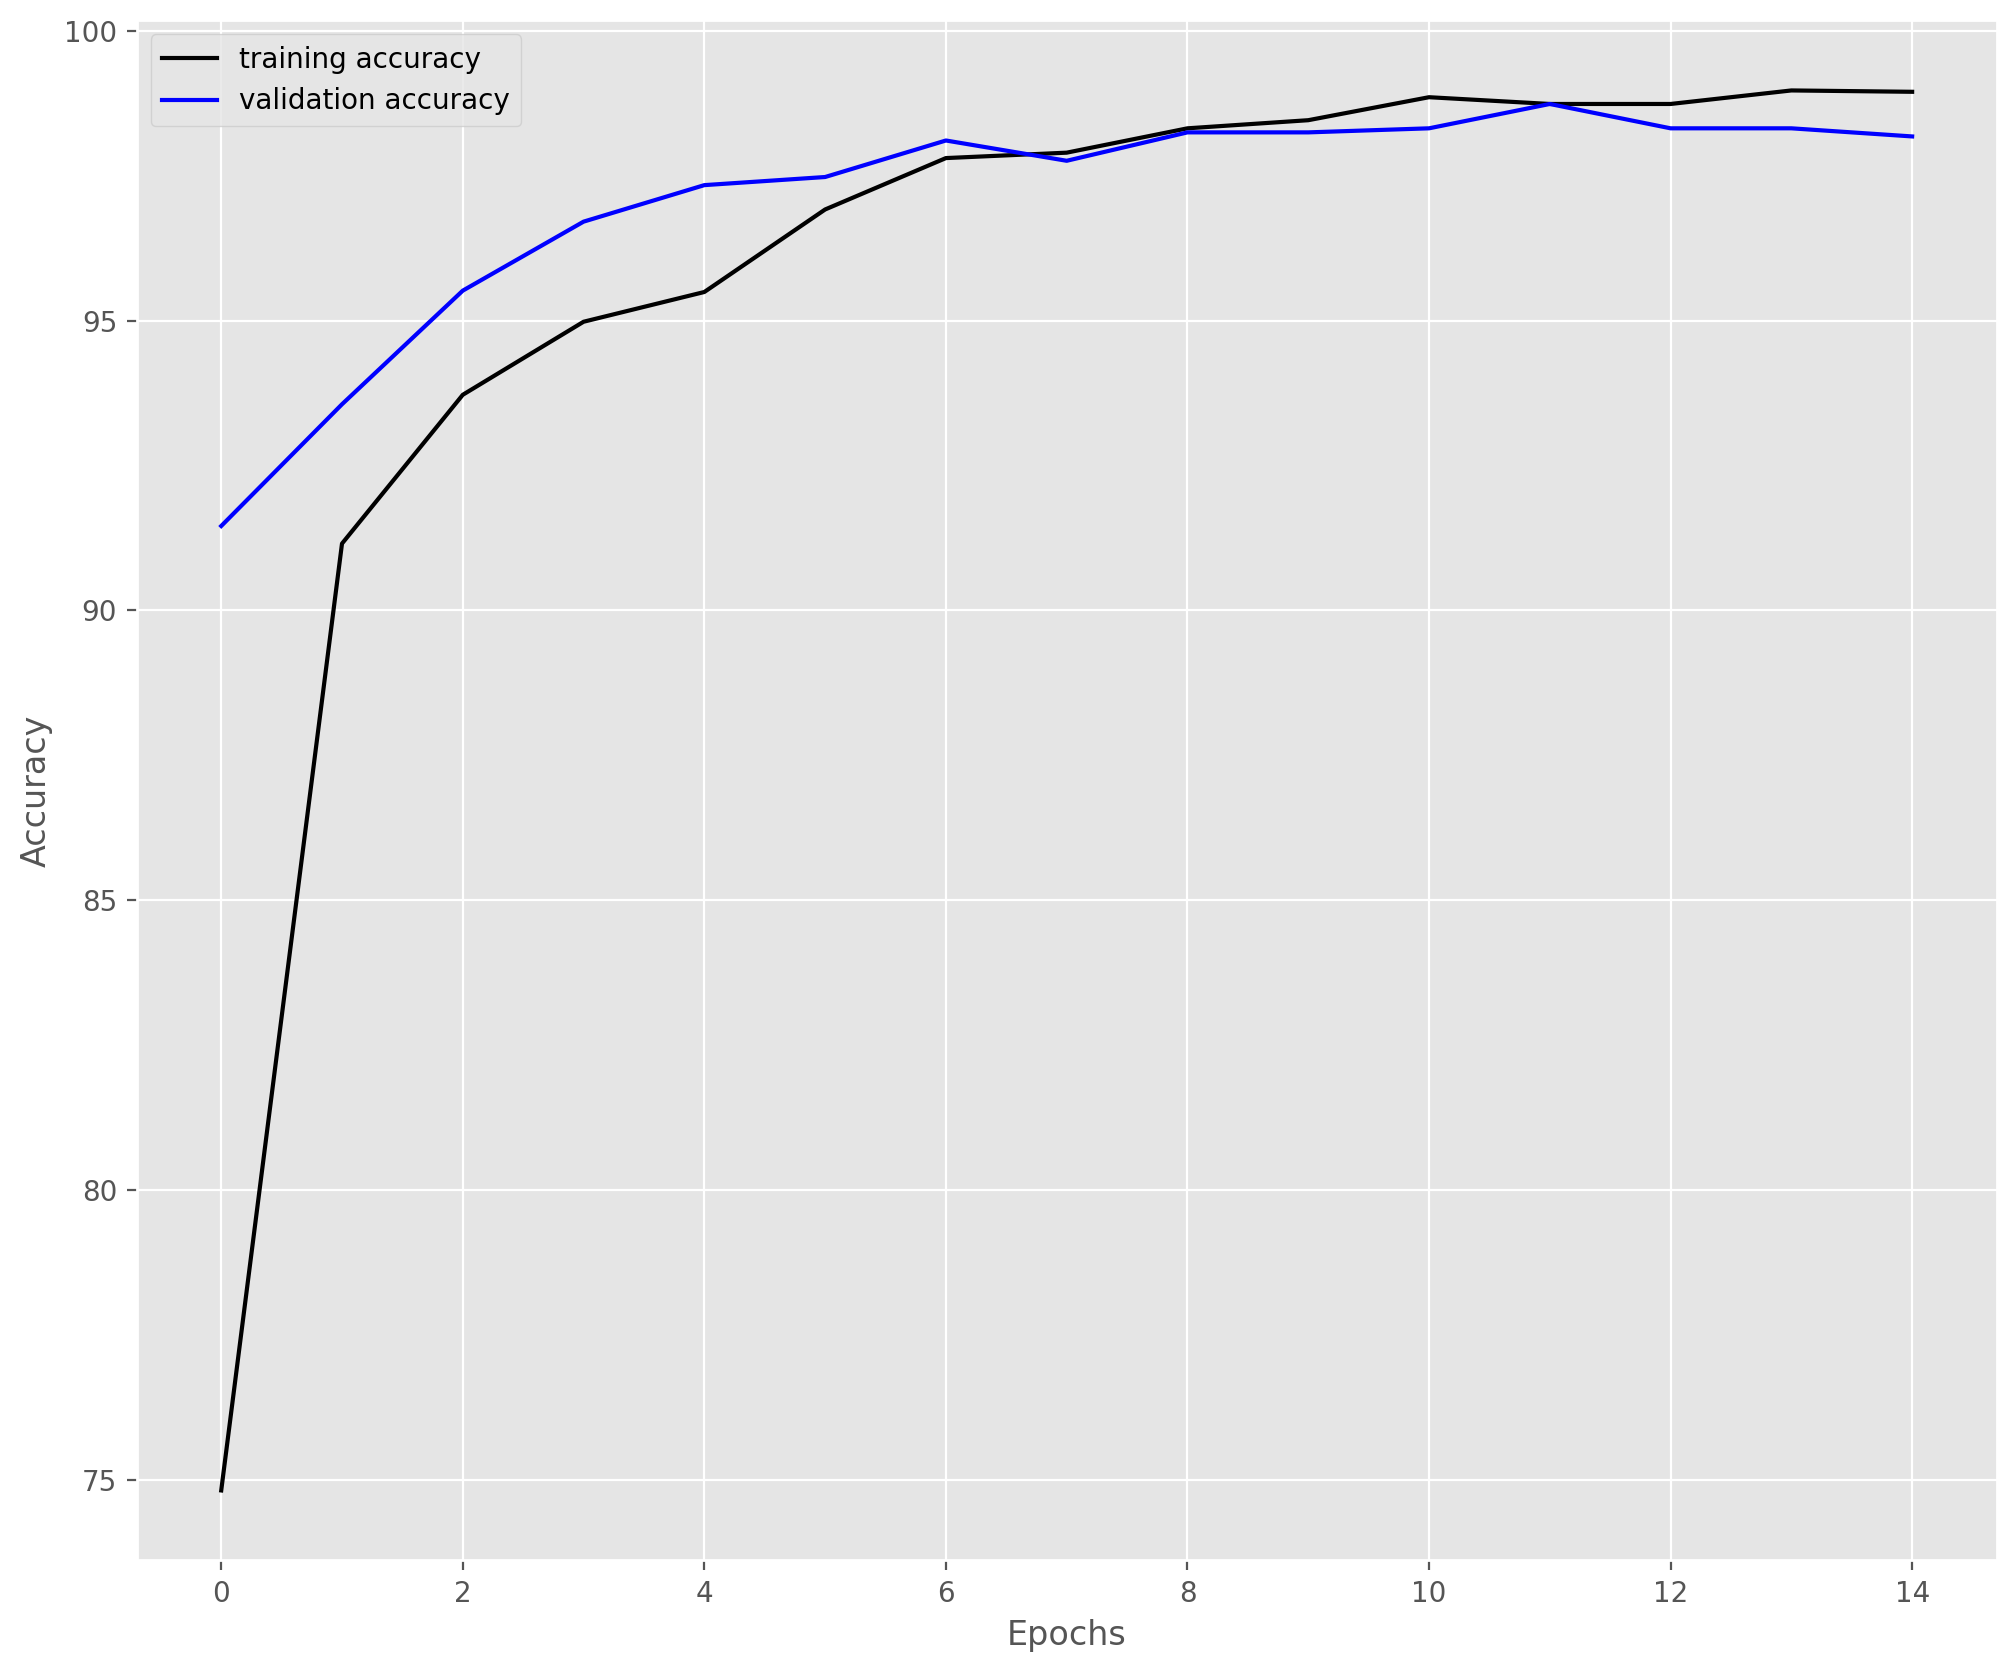

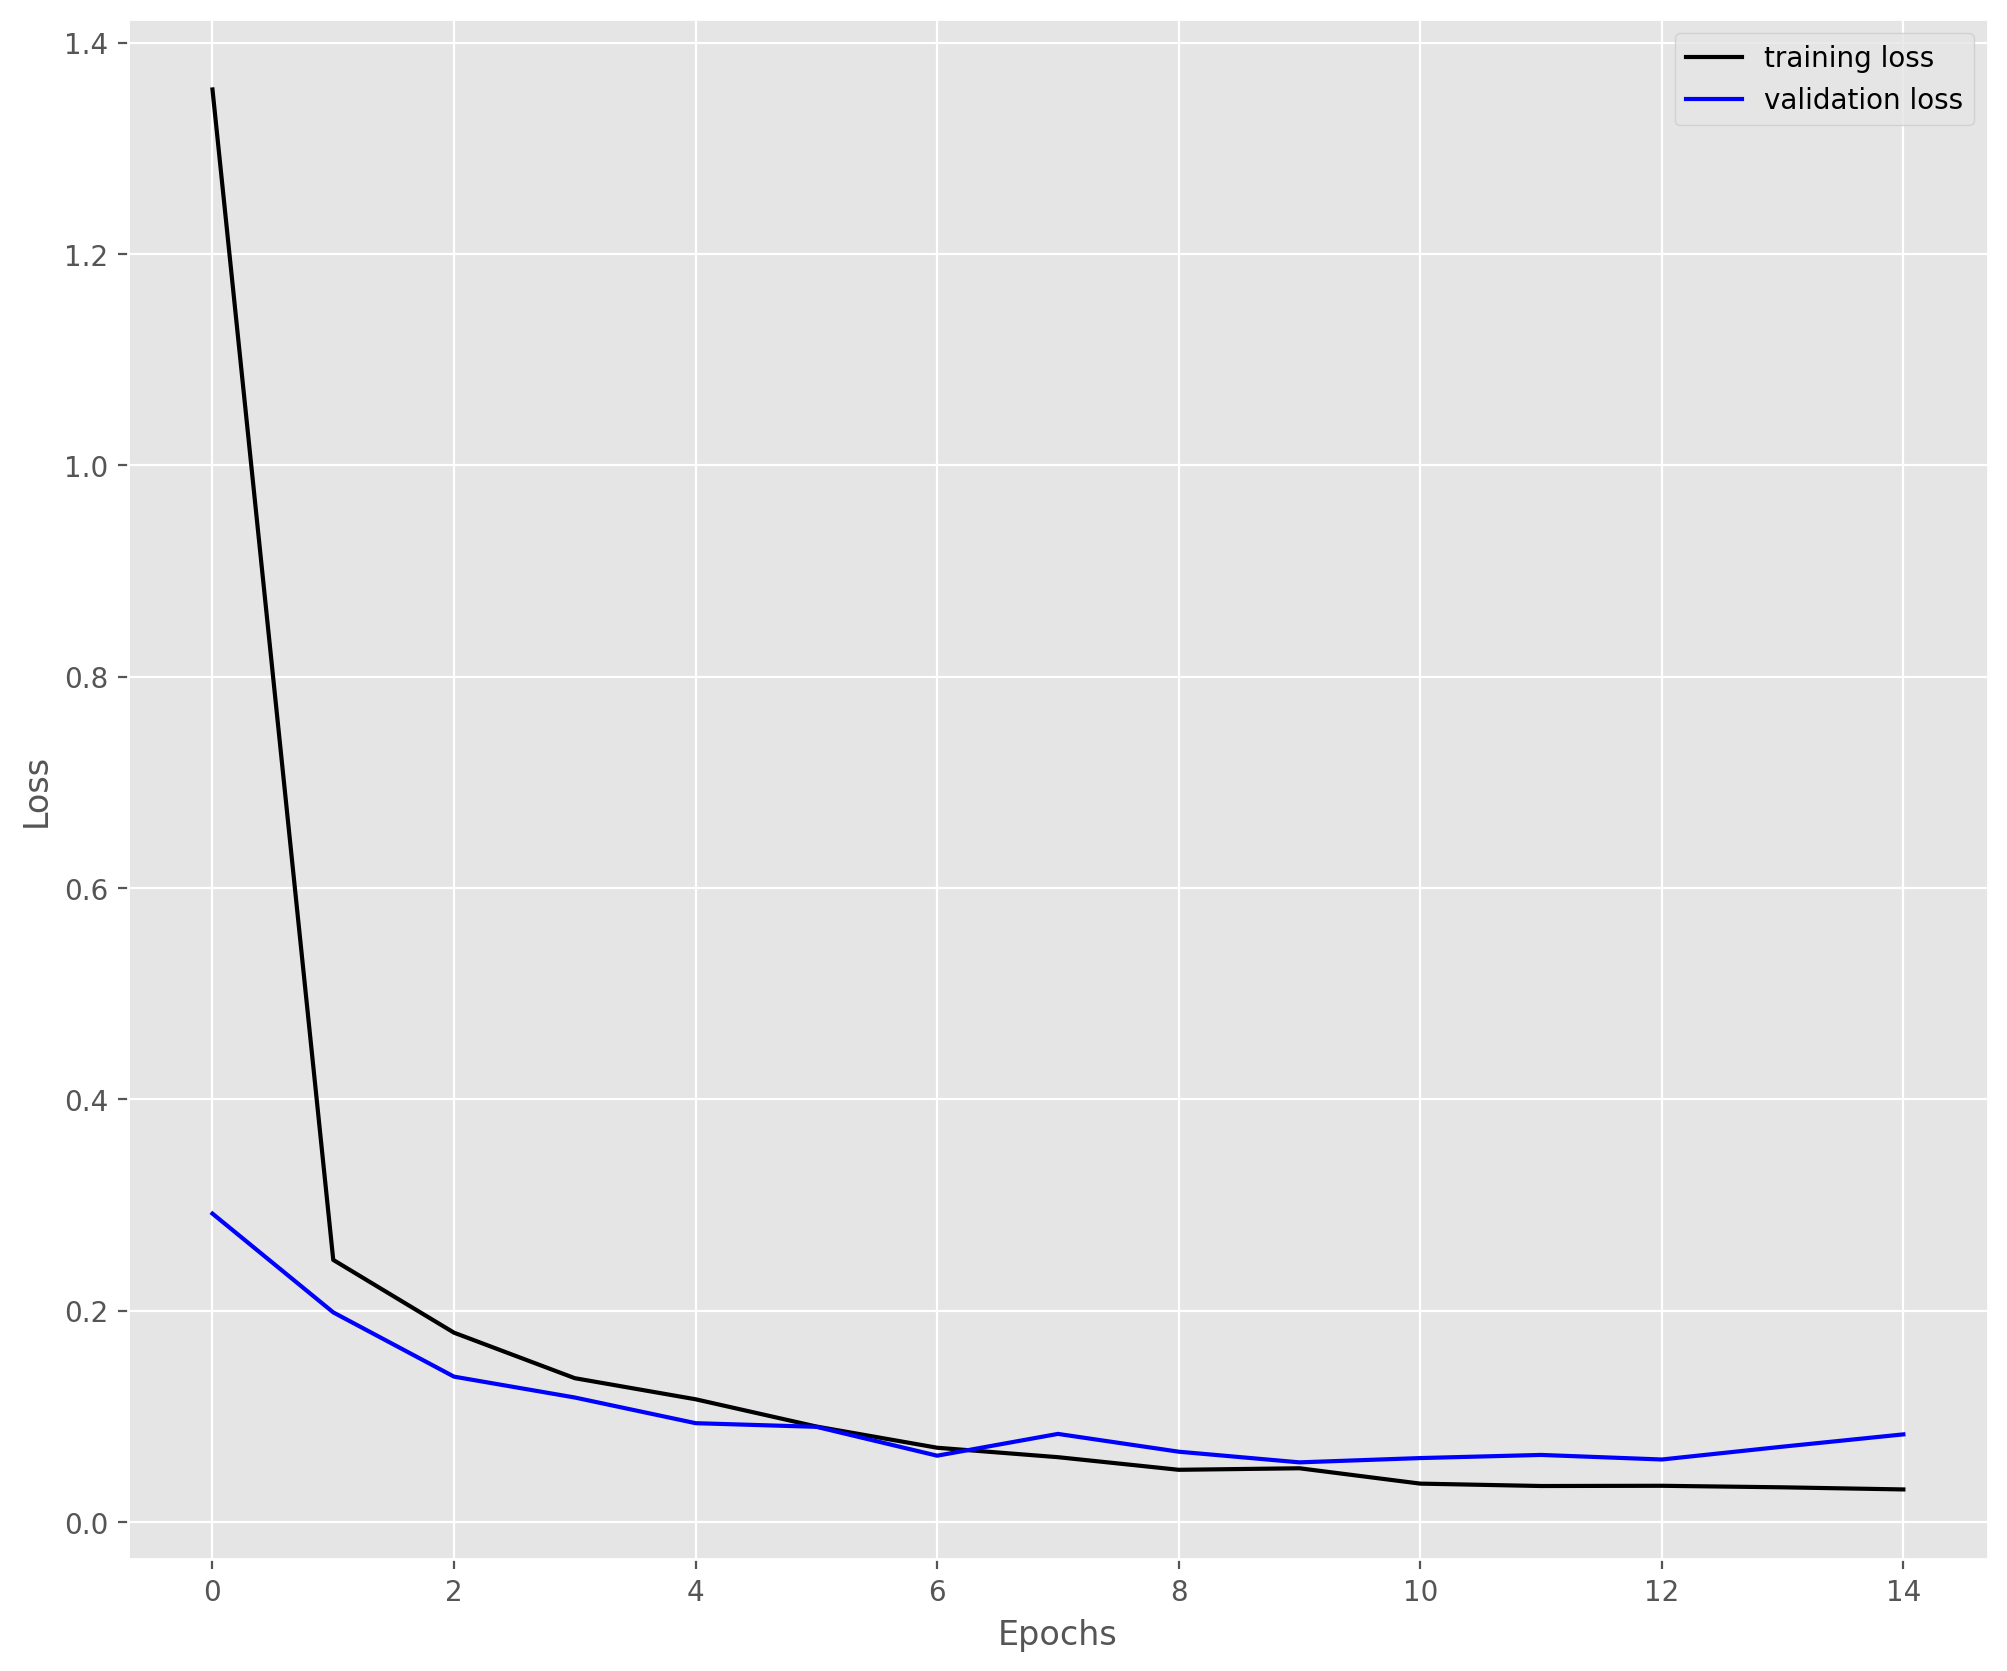

In [19]:
    # Save loss and accuracy plots
save_plots(train_accuracy, validation_accuracy, train_loss, validation_loss)

In [20]:
# Load saved model
model = build_model(pretrained = False, fine_tune = False, num_classes = 4)
checkpoint = torch.load("../outputs2/model.pth", map_location = DEVICE)
#print("Loading saved model")
model.load_state_dict(checkpoint['model_state_dict'])

# Get test files
test_files = glob.glob(f"{TEST_PATH}/*")

# Iterate over images
for test_file in test_files:
    # Get true class name and make copy
    actual_class = test_file.split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_file)
    test_image = image.copy()
    
    # Preprocess images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.465, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(DEVICE)
    
    # Test on image
    outputs = model(image)
    outputs = outputs.detach().numpy()
    predicted_class = class_names[np.argmax(outputs[0])]
    print(f"Predicted: {predicted_class.lower()}\t Actual class: {actual_class}")
    
    # Inscribe the text onto the images
    cv2.putText(
        test_image,
        f"Actual: {actual_class}",
        (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (100, 200, 125),
        1,
        lineType = cv2.LINE_AA
    )
    cv2.putText(
        test_image,
        f"Predicted: {predicted_class.lower()}",
        (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (65, 65, 155),
        1,
        lineType = cv2.LINE_AA
    )
    

    cv2.imwrite(f"../outputs2/{actual_class}.png", test_image)

Loaded pretrained weights for efficientnet-b0
Predicted: pituitary	 Actual class: g
Predicted: glioma	 Actual class: g_1
Predicted: pituitary	 Actual class: m
Predicted: meningioma	 Actual class: m_1
Predicted: notumor	 Actual class: nt
Predicted: pituitary	 Actual class: nt_1
Predicted: pituitary	 Actual class: p
Predicted: pituitary	 Actual class: p_1
